# Customer Referrals Analysis

**Problem: 'Increase signups from the company's referral scheme'**
    
The aim of this analysis is to understand when members usually refer other people after joining and,
whether referring is impacted by other factors such as the sign up channel of the referrer.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import datetime
from statistics import mode 

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## I. Data Cleaning

In [2]:
# loading the data & printing the header

customer_info = pd.read_csv('Customer_Info_2.csv')
referrals_info = pd.read_csv('Referrals_Info.csv')

In [3]:
print(customer_info.dtypes)
print('')
print(referrals_info.dtypes)

customer_id         int64
sign_up_date       object
sign_up_channel    object
dtype: object

referral_date           object
referrer_customer_id     int64
sign_up_customer_id      int64
dtype: object


In [4]:
# printing the header

customer_info.head(1)

,customer_id,sign_up_date,sign_up_channel
0,2543,2021-04-26,Price Comparison Website


In [5]:
# Converting date to a datatime type 

customer_info['sign_up_date'] = pd.to_datetime(customer_info['sign_up_date'])
customer_info.sort_values(by='sign_up_date',inplace=True)
customer_info.tail(1)

,customer_id,sign_up_date,sign_up_channel
1647,2681,2022-01-03,Price Comparison Website


In [6]:
# Returning the most recent sign up date

most_recent_date = str(customer_info.sign_up_date.iloc[-1].date())

In [7]:
# Creating a new feature to capture how long the customer has been with the company

now = datetime.datetime.strptime(most_recent_date, '%Y-%m-%d')
customer_info['time_since_join'] = (now - customer_info['sign_up_date']).dt.days

In [8]:
customer_info['sign_up_month_year'] = [d.strftime('%Y-%m') for d in customer_info['sign_up_date']]

In [9]:
customer_info.head(1)

,customer_id,sign_up_date,sign_up_channel,time_since_join,sign_up_month_year
1029,790,2019-05-07,Company's Website,972,2019-05


In [10]:
referrals_info.head()

,referral_date,referrer_customer_id,sign_up_customer_id
0,2021-07-18,795,1771
1,2021-04-12,577,1510
2,2021-07-07,868,1858
3,2021-10-25,801,1778
4,2021-08-15,690,1637


In [11]:
# Converting date to a datatime type 

referrals_info['referral_date'] = pd.to_datetime(referrals_info['referral_date'])
referrals_info.sort_values(by='referral_date',inplace=True)
referrals_info.tail(1)

,referral_date,referrer_customer_id,sign_up_customer_id
13,2022-01-03,292,1696


In [12]:
# Overview of both datasets 

print('Customer dataset info:')
print(customer_info.info())
print('')
print('Referrals dataset info:')
print(referrals_info.info())

Customer dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 1029 to 1647
Data columns (total 5 columns):
customer_id           1699 non-null int64
sign_up_date          1699 non-null datetime64[ns]
sign_up_channel       1699 non-null object
time_since_join       1699 non-null int64
sign_up_month_year    1699 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 79.6+ KB
None

Referrals dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 792 to 13
Data columns (total 3 columns):
referral_date           1000 non-null datetime64[ns]
referrer_customer_id    1000 non-null int64
sign_up_customer_id     1000 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 31.2 KB
None


## II. EDA

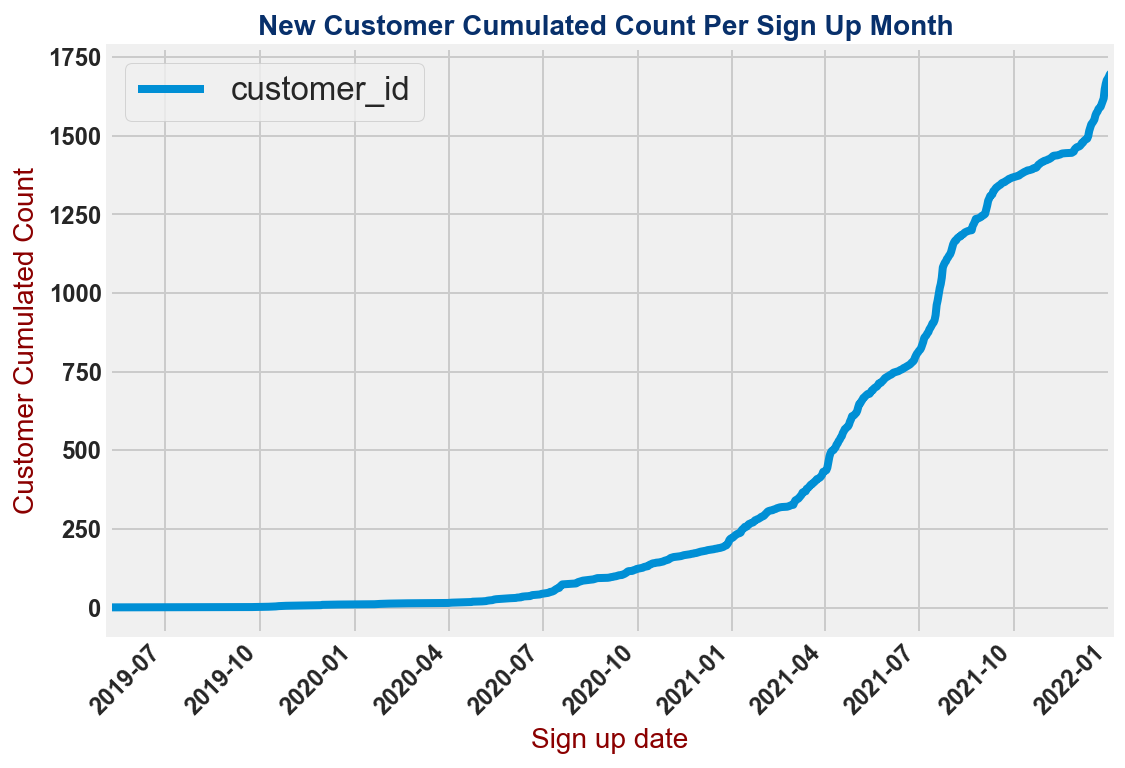

In [13]:
# Plotting the trend in customer sign up

customer_info.groupby('sign_up_date')[['customer_id']].count().cumsum().plot(figsize=(8,6))

plt.style.context('bluescale')

plt.xlabel('Sign up date',fontsize=14,color='DarkRed')
plt.ylabel('Customer Cumulated Count',fontsize=14,color='DarkRed')

plt.xticks(label=customer_info.sign_up_date, rotation=45)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)


plt.title('New Customer Cumulated Count Per Sign Up Month ',fontsize=14,color='#08306b',fontweight='bold')

plt.show()


In [14]:
# Checking how many customers referred more than once

referrals_info['referrer_customer_id'].value_counts()[referrals_info['referrer_customer_id'].value_counts()> 1].nunique()

10

In [52]:
# Keeping only the first referral in case of multiple referrals

unique_referrals = referrals_info.sort_values(by=['referrer_customer_id','referral_date'])
unique_referrals.drop_duplicates(subset='referrer_customer_id',keep='first',inplace=True)
unique_referrals.head(10)

,referral_date,referrer_customer_id,sign_up_customer_id
484,2021-05-29,0,869
323,2021-12-23,1,870
246,2021-04-10,2,871
10,2021-12-30,3,872
76,2021-08-16,4,873
373,2021-07-24,5,874
734,2021-01-17,6,889
814,2021-05-24,7,876
616,2021-02-07,8,1737
956,2021-11-22,9,878


In [71]:
unique_referrals.shape

(869, 3)

In [73]:
multiple_referrals_prob = 10 / 869

multiple_referrals_prob

0.011507479861910242

### 1) When do members refer ?

In [16]:
def data_selection(customer_info,referrals_info):
    
    # Merging both DataFrames to combine all relevant information
    # Filtering on the referrer_id contained in the customer_id sample file
    
    combined_df = pd.merge(customer_info[['customer_id','sign_up_date','sign_up_channel','time_since_join','sign_up_month_year']],\
                           referrals_info[['referrer_customer_id','referral_date']],\
                           left_on='customer_id',right_on='referrer_customer_id',how='left',indicator=True)

    combined_df.replace({'both':1,'left_only':0},inplace=True) # 1 = has referred at least once

    combined_df = combined_df.rename(columns={'_merge':'referrer'})
    
    # Extracting Month-Year from referral date & adding new column with lag between sign up and first referral
    
    combined_df['referral_month_year'] = combined_df['referral_date'].apply(lambda x: x.strftime('%Y-%m') \
                                                                         if len(str(x)) > 4 else np.nan)

    combined_df['sign_up_to_referral_lag'] = (combined_df['referral_date'] - combined_df['sign_up_date']).dt.days
    
    # Returning total referrer and total customers per sign up date & creating new dataframe 

    referrer_count_per_sign_up_date = combined_df.groupby('sign_up_month_year')[['referrer']].sum()
    total_count_per_sign_up_date = combined_df.groupby(['sign_up_month_year'])[['customer_id']].count()

    total_count_per_sign_up_date.reset_index(inplace=True)
    referrer_count_per_sign_up_date.reset_index(inplace=True)

    referrer_prop_per_sign_up_date = pd.merge(referrer_count_per_sign_up_date,total_count_per_sign_up_date,\
                                               right_on='sign_up_month_year',left_on='sign_up_month_year',how='left')


    referrer_prop_per_sign_up_date = referrer_prop_per_sign_up_date.rename(columns={'customer_id':'total_count'})

    referrer_prop_per_sign_up_date['proportion_of_referrer'] = (referrer_prop_per_sign_up_date['referrer']\
                                                                                  / referrer_prop_per_sign_up_date['total_count']).round(2)


    return combined_df,referrer_prop_per_sign_up_date


In [17]:
def plotting_summaries(referrer_prop_per_sign_up_date):

    fig, (ax1) = plt.subplots(1,figsize=[10,6])
    

    referrer_prop_per_sign_up_date.plot.bar(x='sign_up_month_year',y=['referrer','total_count'],rot=80,ax=ax1)

    ax1.set_xlabel('Date',fontsize=14,color='DarkRed')
    ax1.set_ylabel('Count (log scale)',fontsize=12,color='DarkRed')
    ax1.set_title('Proportion of Referrers Per Sign Up Month',fontsize=14,color='#08306b',fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.legend(loc='upper left',fontsize='medium')
    ax1.set_yscale('log')

    fig.tight_layout(pad=3.0)
        

In [18]:
def testing_scenario(scenario,referrals_info):
    # Function that allows filtering the main dataset and returning the underlying dataframes and plots
    
    customer_info = scenario
    [combined_df,referrer_prop_per_sign_up_date] = data_selection(customer_info,referrals_info)
    
    join_to_referrer_lag = combined_df[~(combined_df.sign_up_to_referral_lag.isnull())]['sign_up_to_referral_lag']
    
    print('Overview of the duration between sign up and referral')
    print('')
    print(join_to_referrer_lag.describe())
    print('')
    print('Most frequent lag is %s'% (mode(join_to_referrer_lag)))

    plotting_summaries(referrer_prop_per_sign_up_date)
    
    fig,ax = plt.subplots(1,figsize=[8,6])
    sns.distplot(join_to_referrer_lag,kde=False,ax=ax)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_ylabel('Referral count',color='DarkRed')
    ax.set_xlabel('Lag length',color='DarkRed')
    ax.set_title('Time Lag In Days Between Joining And Referring',fontsize=14,color='#08306b',fontweight='bold')




In [19]:
# All customers

scenario1 =  customer_info

In [20]:
# Removing new joiners

scenario2 =  customer_info[customer_info.time_since_join > 90]

### A. All customers

Overview of the duration between sign up and referral

count    702.000000
mean     103.081197
std      113.928603
min        0.000000
25%       19.000000
50%       67.000000
75%      153.000000
max      700.000000
Name: sign_up_to_referral_lag, dtype: float64

Most frequent lag is 0.0


/Users/milou/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


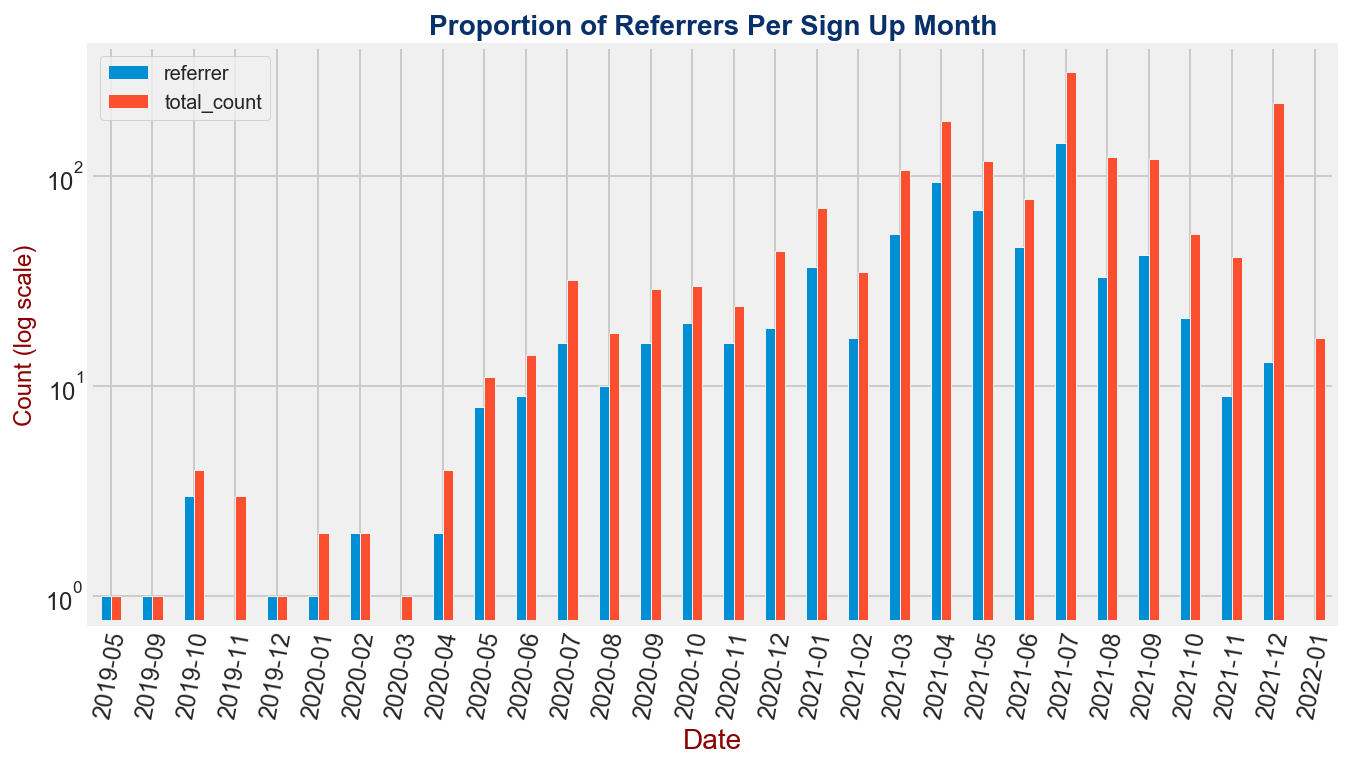

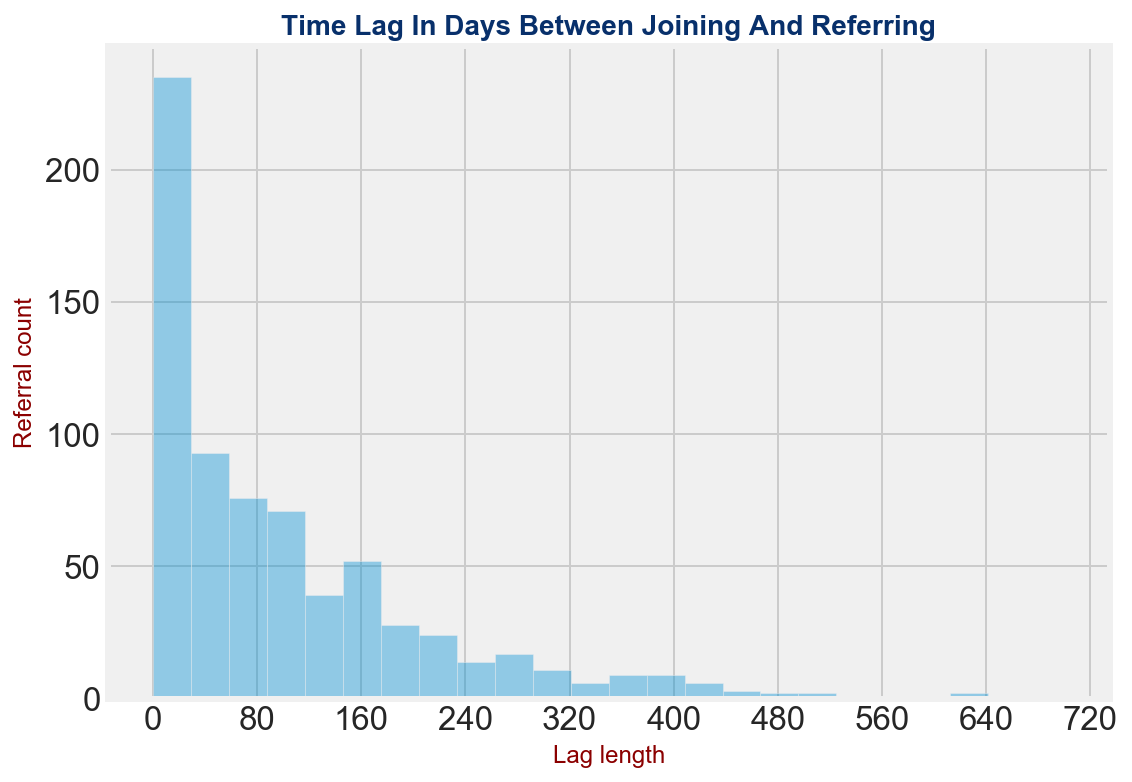

In [21]:
testing_scenario(scenario1,unique_referrals)

### B. Excluding new joiners

Overview of the duration between sign up and referral

count    661.000000
mean     108.199697
std      115.372793
min        0.000000
25%       21.000000
50%       75.000000
75%      157.000000
max      700.000000
Name: sign_up_to_referral_lag, dtype: float64

Most frequent lag is 0.0


/Users/milou/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


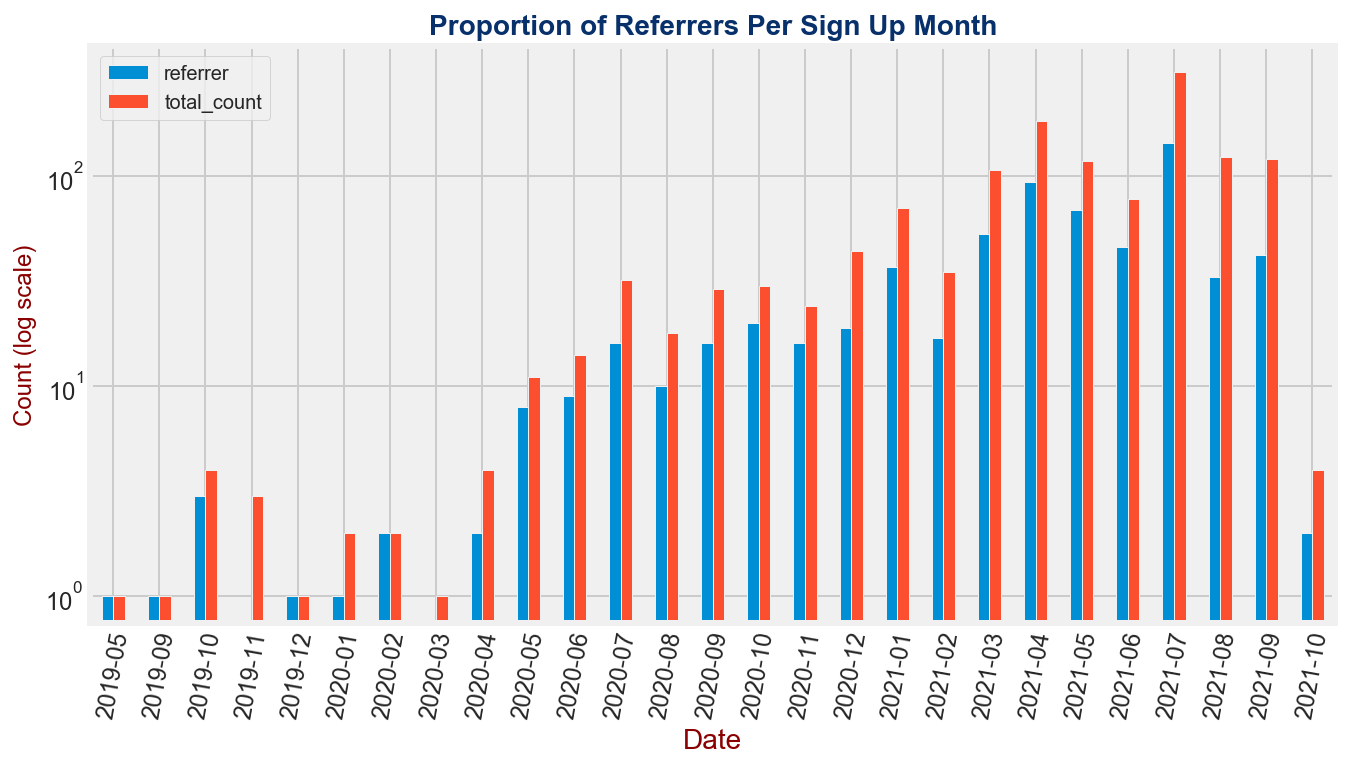

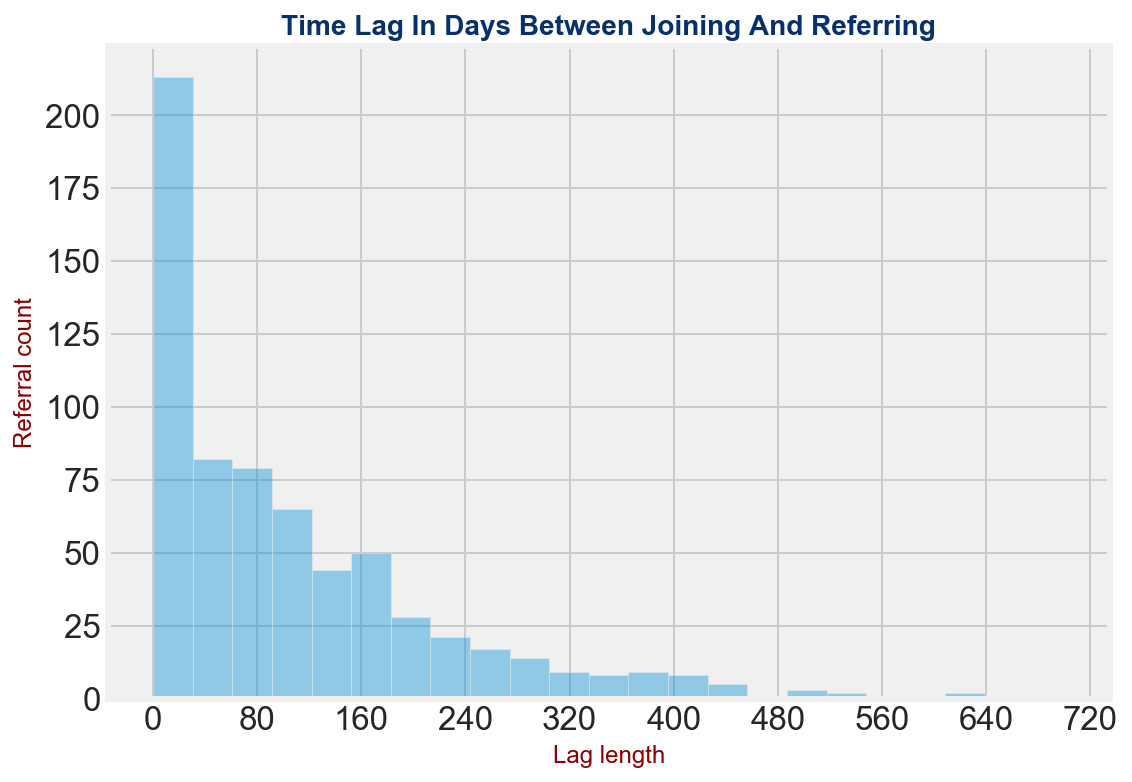

In [50]:
testing_scenario(scenario2,unique_referrals)

In [22]:
[combined_df,referrer_prop_per_sign_up_date] = data_selection(customer_info,unique_referrals)

df1 = combined_df

### C. Distribution comparison 

In [23]:
[combined_df,referrer_prop_per_sign_up_date] = data_selection(customer_info[customer_info.time_since_join > 90],
                                                              unique_referrals)

df2 = combined_df

/Users/milou/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


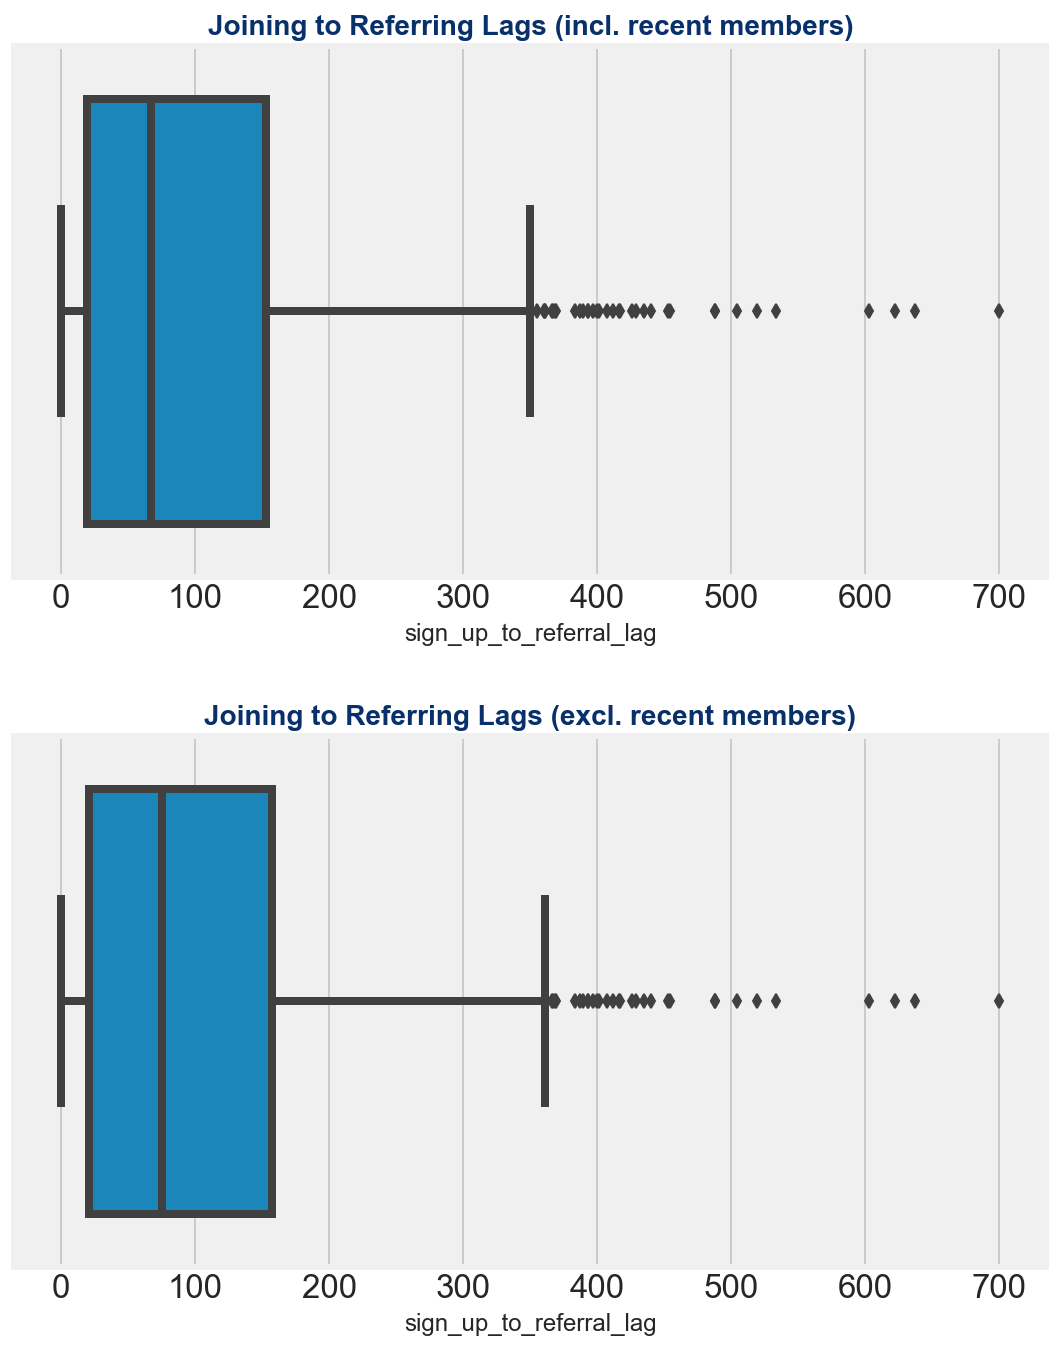

In [24]:
fig,(ax1,ax2) = plt.subplots(2,figsize=[8,10])

sns.boxplot(df1.sign_up_to_referral_lag,ax=ax1)
ax1.set_title('Joining to Referring Lags (incl. recent members)',fontsize=14,color='#08306b',fontweight='bold')

sns.boxplot(df2.sign_up_to_referral_lag,ax=ax2)
ax2.set_title('Joining to Referring Lags (excl. recent members)',fontsize=14,color='#08306b',fontweight='bold')

fig.tight_layout(pad=3.0)


### D. Late referrers analysis

In [55]:
[combined_df,referrer_prop_per_sign_up_date] = data_selection(customer_info[customer_info.time_since_join > 90],
                                                              unique_referrals)

In [56]:
# Filtering customers who referred for the first time after having joined the company 
# for a long time (over 5 months)

long_lag = combined_df[combined_df.sign_up_to_referral_lag >167]
long_lag.shape

(147, 10)

In [57]:
# Returning the proportion of 'late referrers' per sign up date

late_referrer_count_per_sign_up_date = long_lag.groupby('sign_up_month_year')[['referrer']].sum()
total_count_per_sign_up_date = referrer_prop_per_sign_up_date[['sign_up_month_year','total_count']]

In [58]:
late_referrer_count_per_sign_up_date.reset_index(inplace=True)

In [59]:
late_referrer_count_per_sign_up_date = pd.merge(late_referrer_count_per_sign_up_date,total_count_per_sign_up_date,\
                                           right_on='sign_up_month_year',left_on='sign_up_month_year',how='left')


late_referrer_count_per_sign_up_date = late_referrer_count_per_sign_up_date.rename(columns={'customer_id':'total_count'})


late_referrer_count_per_sign_up_date['proportion_of_late_referrer'] = (late_referrer_count_per_sign_up_date['referrer']\
                                                                              / late_referrer_count_per_sign_up_date['total_count']).round(2)
late_referrer_count_per_sign_up_date.head()

,sign_up_month_year,referrer,total_count,proportion_of_late_referrer
0,2019-05,1,1,1.0
1,2019-09,1,1,1.0
2,2019-10,2,4,0.5
3,2019-12,1,1,1.0
4,2020-01,1,2,0.5


In [60]:
# Returning the proportion of 'late referrers' per referral date

late_referrals_date = long_lag.groupby(['referral_month_year'])[['customer_id']].count()
late_referrals_date.reset_index(inplace=True)
late_referrals_date = late_referrals_date.rename(columns={'customer_id':'late_referral_count'})

Text(0, 0.5, 'Count')

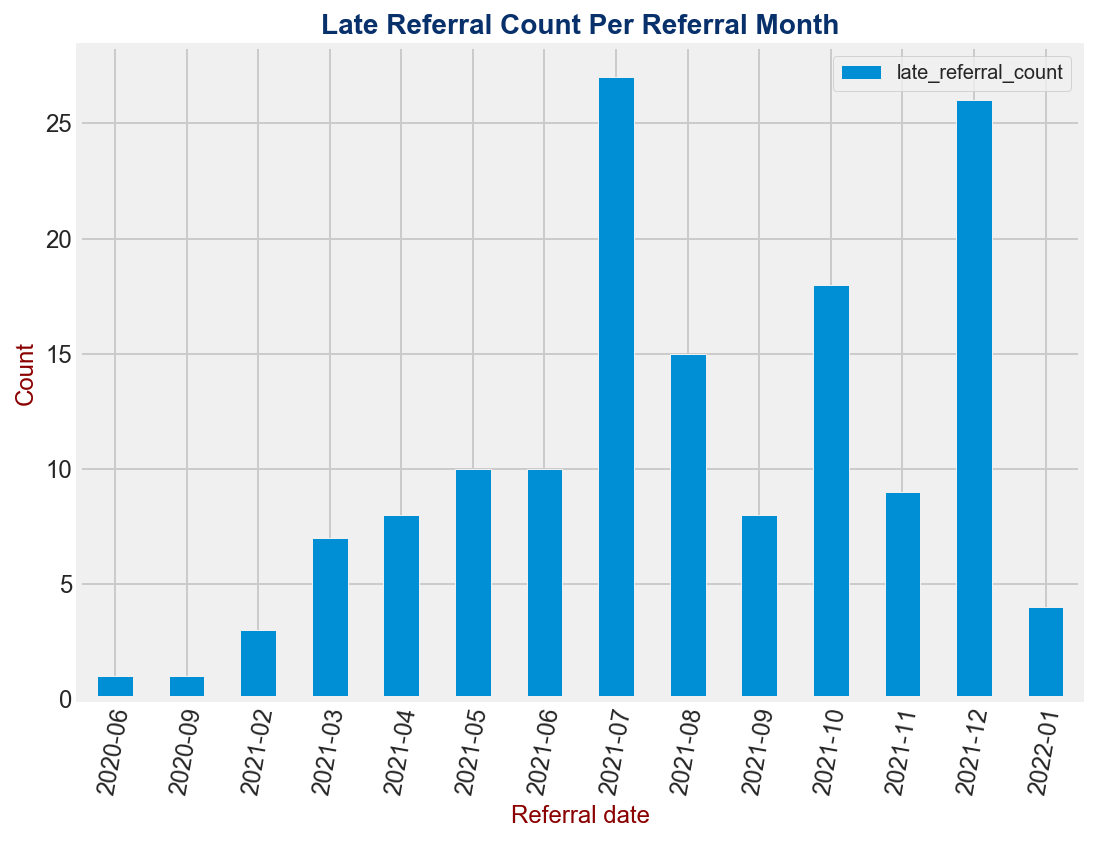

In [61]:
# Plotting the data

ax = late_referrals_date.plot.bar(x='referral_month_year',rot=80,figsize=[8,6])
ax.set_title('Late Referral Count Per Referral Month',fontsize=14,color='#08306b',fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper right',fontsize='medium')
ax.set_xlabel('Referral date',color='DarkRed')
ax.set_ylabel('Count',color='DarkRed')

Text(0, 0.5, 'Count')

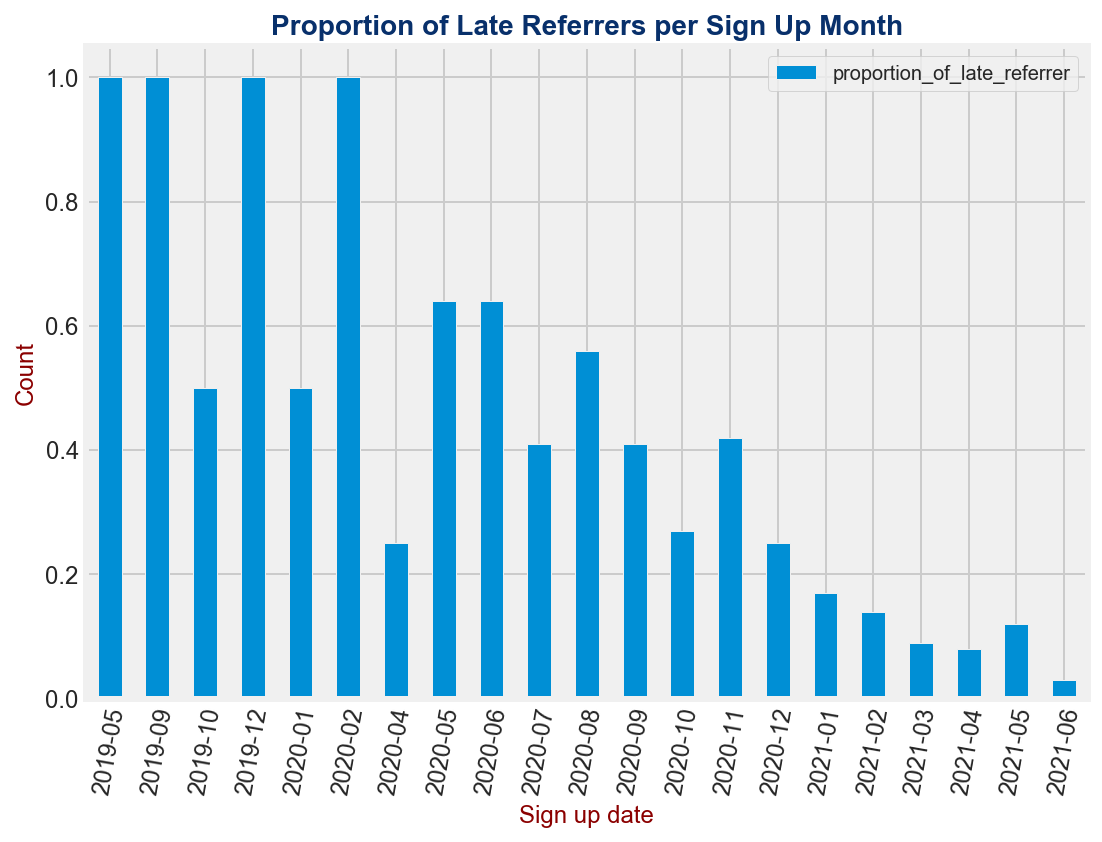

In [62]:
ax = late_referrer_count_per_sign_up_date.plot.bar(x='sign_up_month_year',y='proportion_of_late_referrer',rot=80,\
                                        figsize=[8,6])
ax.set_title('Proportion of Late Referrers per Sign Up Month',fontsize=14,color='#08306b',fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper right',fontsize='medium')
ax.set_xlabel('Sign up date',color='DarkRed')
ax.set_ylabel('Count',color='DarkRed')



In [63]:
# Sign up channel of late referrers

long_lag.groupby('sign_up_channel')[['referrer']].sum()

,referrer
sign_up_channel,
Company's Website,46
Price Comparison Website,60
Referral,41


## III. Statistical Analysis

### 2) Does the sign up channel impact referrals ?

In [64]:
import scipy.stats as stats

In [65]:
# df2 = combined_df without new customers

df2.sign_up_channel.unique()

array(["Company's Website", 'Price Comparison Website', 'Referral'],
      dtype=object)

In [66]:
# referrer proportion per sign up channel

df2.groupby('sign_up_channel')[['referrer']].agg(['mean','count'])

referrer      
                              mean count
sign_up_channel                         
Company's Website         0.517241   290
Price Comparison Website  0.296667   600
Referral                  0.692308   481

In [67]:
# Creating a contingency table 

cross_tab = pd.crosstab(df2.sign_up_channel, df2.referrer)
cross_tab

referrer,0,1
sign_up_channel,,
Company's Website,140,150
Price Comparison Website,422,178
Referral,148,333


In [68]:
# Testing significance with a Chi-square test

chi2,p_value,dof,expected = stats.chi2_contingency(cross_tab)
chi2,p_value,dof

(169.19018269769822, 1.8231341708718541e-37, 2)

In [69]:
# Select significance value

alpha = 0.05

# Determine whether to reject or keep the null hypothesis

print('significance=%.3f, p=%.3f' % (alpha, p_value))
if p_value <= alpha:
    print('Sign up channel has some effect (reject H0)')
else:
    print('Sign up channel has no effect(fail to reject H0)')

significance=0.050, p=0.000
Sign up channel has some effect (reject H0)


In [70]:
# original code from https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/

from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

all_combinations = list(combinations(cross_tab.index, 2))  # gathering all combinations for post-hoc chi2
p_vals = []
print("Significance results:")

for comb in all_combinations:
    new_cross_tab = cross_tab[(cross_tab.index == comb[0]) | (cross_tab.index == comb[1])]
    chi2, p, dof, ex = stats.chi2_contingency(new_cross_tab, correction=True)
    p_vals.append(p)

# checking significance
# correction for multiple testing
reject_list, corrected_p_vals = multipletests(p_vals, method='bonferroni')[:2]
for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
    print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f}  reject: {reject}")

Significance results:
("Company's Website", 'Price Comparison Website'): p_value: 0.000000; corrected: 0.000000  reject: True
("Company's Website", 'Referral'): p_value: 0.000002; corrected: 0.000005  reject: True
('Price Comparison Website', 'Referral'): p_value: 0.000000; corrected: 0.000000  reject: True
